In [1]:
import sys
sys.path.append('..')

In [18]:
from datetime import datetime
from pathlib import Path
from itertools import product, combinations
from operator import itemgetter

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

from cashback_calculator.db import Card, N_MCCS, ALL_MCCS, MCC2ID, ID2MCC, \
    MCC_CATEGORIES, CARD_IDS
from cashback_calculator.two_card_strategy_optimisation import optimize_cashback, \
    optimize_cashback_for_cards

from myutils.json import save_json, load_json

# %config InlineBackend.figure_formats = ['svg']
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette('deep'))
plt.rcParams['grid.linestyle'] = 'dotted'

In [74]:
rcparams = {
    'text.usetex' : True,
    'font.family': [
        'serif'
    ],
    'font.serif': [
        'Computer Modern Roman',
        'Times',
        'Palatino',
        'New Century Schoolbook',
        'Bookman',
    ],
}

plt.rcParams.update(rcparams)

In [4]:
dblue = '#27488b'
lblue = '#6d92de'
dred = '#d91f43'

In [5]:
money_movement = pd.read_csv('../data/money_movement.csv', dtype={'mcc': str}, parse_dates=['date'])

date_mask = (money_movement['date'] >= datetime(year=2019, month=12, day=1))\
    & (money_movement['date'] < datetime(year=2020, month=12, day=1))

money_movement = money_movement[date_mask].reset_index(drop=True)

money_movement['month'] = money_movement['date'].apply(lambda x: x.replace(day=1))

money_movement.head(2)

,date,income,expense,mcc,is_cashback,month
0,2019-12-01,0.0,288.0,5814,False,2019-12-01
1,2019-12-01,0.0,200.0,5411,False,2019-12-01


## Testing workability

In [6]:
month = money_movement['month'].unique()[-1]
month

numpy.datetime64('2020-11-01T00:00:00.000000000')

In [7]:
spendings = money_movement.loc[money_movement['month'] == month].groupby('mcc')['expense'].sum()
vector = spendings.reindex(ALL_MCCS).fillna(0).values * 1.5

vector.shape, vector.sum()

((572,), 90683.78999999998)

In [8]:
cards = [Card(card_id) for card_id in CARD_IDS]

len(cards)

14

In [9]:
c1 = cards[5]
c2 = cards[9]

c1, c2

(Card(card_id='bspb_visa-cashback', bank_id='bspb'),
 Card(card_id='bspb_travel', bank_id='bspb'))

In [10]:
c1.benchmarks, c2.benchmarks

(array([ 0., inf]), array([ 0., inf]))

In [11]:
result = optimize_cashback(vector, cards, progress_bar=True)

result[0][-1]

  0%|          | 0/91 [00:00<?, ?it/s]

3357.607800044737

## Testing time complexity

In [12]:
runtime = load_json('../data/tests/speed_test_results.json')

runtime = pd.DataFrame(runtime, columns=['n', 't'])

runtime.head(2)

,n,t
0,2.0,0.000172
1,2.0,0.003991


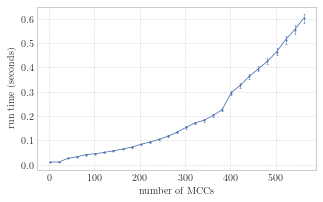

In [76]:
plt.figure(figsize=(5, 3))

sns.lineplot(data=runtime, x='n', y='t', lw=0.8, color='C0',
             marker='.', markersize=4, markeredgewidth=0,
             zorder=5,
             err_style='bars', err_kws={'linewidth': 0.5, 'ecolor': 'C0', 'capsize': 1.2, 'capthick': 0.5})

plt.xlabel('number of MCCs')
plt.ylabel('run time (seconds)')

plt.savefig('../data/figures/runtime.pdf', transparent=True, bbox_inches='tight')

## Testing vs. brute force

In [20]:
mcc_categories = {
    category: mccs[:1]
    for category, mccs in MCC_CATEGORIES.items()
}

mcc2category = {
    mcc: category
    for category, mccs in mcc_categories.items()
    for mcc in mccs
}

mcc2category

{'5811': 'restaurants',
 '5814': 'fastfood',
 '5541': 'fuel',
 '4121': 'taxi',
 '5411': 'groceries',
 '5912': 'pharmacies',
 '7832': 'cinema',
 '3000': 'airlines',
 '1711': 'other'}

In [21]:
def get_vector(amount_spent_by_category) -> np.ndarray:
    vector = np.zeros(N_MCCS)
    
    for key, value in amount_spent_by_category.items():
        if value > 0:
            value -= 0.01
            mccs = mcc_categories[key]
            n_mccs = len(mccs)
            mask = list(map(MCC2ID.get, mccs))
            vector[mask] = value / n_mccs
            
    return vector

In [22]:
category_values = [
    ('restaurants', 15000, 3000),
    ('fastfood', 5000, 1000),
    ('fuel', 1500, 500),
    ('taxi', 2500, 500),
    ('groceries', 1800, 2000),
    ('pharmacies', 2000, 1000),
    ('cinema', 3500, 1000),
    ('airlines', 10000, 4000),
    ('other', 20000, 1500)
]

In [23]:
def get_random_spendings_vector(n_values: int = 6) -> np.ndarray:
    inds = np.random.choice(np.arange(len(category_values)), size=n_values, replace=False)
    amount_spent_by_category = {}
    
    for i in inds:
        name, mu, sigma = category_values[i]
        amount = np.random.normal(mu, sigma)
        amount_spent_by_category[name] = amount
        
    vector = get_vector(amount_spent_by_category)
    vector[vector < 0] = 0
    
    return vector * 2

In [24]:
vector = get_random_spendings_vector(6)

vector.sum()

76198.92263467779

In [25]:
def maximize_profit_brute_force(
        spendings_vector: np.ndarray,
        c1: Card,
        c2: Card,
        grid_size: int = 3,
        progress_bar: bool = False,
) -> float:
    nonzero_ids = np.where(spendings_vector > 0)[0]
    
    grid = list(product(np.linspace(0, 1, grid_size), repeat=len(nonzero_ids)))
    results = []
    
    for values in tqdm(grid, disable=not progress_bar):
        x = np.zeros(spendings_vector.size)
        x[nonzero_ids] = np.array(list(values))
        
        profit = c1.calculate_profit(spendings_vector * x) + c2.calculate_profit(spendings_vector * (1 - x))
        results.append((x, profit))
            
    x, profit = max(results, key=itemgetter(1))
    
    return x, profit

In [29]:
cards[0].card_id

'tinkoff_black'

In [58]:
results = pd.read_csv('../data/tests/vs_brute_force.csv')

results['c1'] = results['c1'].apply(Card)
results['c2'] = results['c2'].apply(Card)

results.head(2)

,c1,c2,opt,bf,diff,mape
0,"Card(card_id='bspb_yarkaya', bank_id='bspb')",Card(card_id='sberbank_karta-s-bolshimi-bonusa...,2667.740544,2607.907967,0.022428,-0.022943
1,"Card(card_id='bspb_visa-cashback', bank_id='bs...","Card(card_id='alfabank_cashback', bank_id='alf...",4055.062390,4013.394395,0.010276,-0.010382


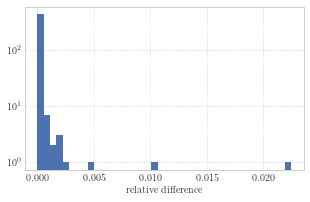

In [77]:
plt.figure(figsize=(5, 3))

hist = plt.hist(results['diff'], bins=40, zorder=5)

plt.xlabel('relative difference')
plt.yscale('log')

plt.savefig('../data/figures/vs_brute_force.pdf', transparent=True, bbox_inches='tight')

## Results on real data

<AxesSubplot:xlabel='month'>

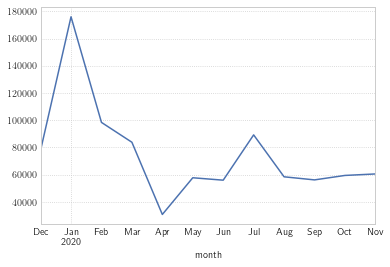

In [62]:
monthly_spendings = money_movement.groupby('month')['expense'].sum()

monthly_spendings.plot()

<AxesSubplot:xlabel='month'>

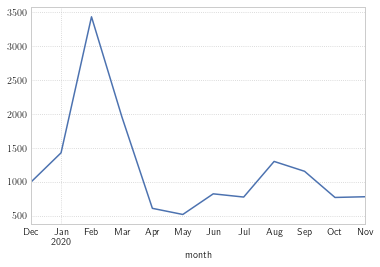

In [63]:
monthly_cashback = money_movement[money_movement['is_cashback']].groupby('month')['income'].sum()

monthly_cashback.plot()

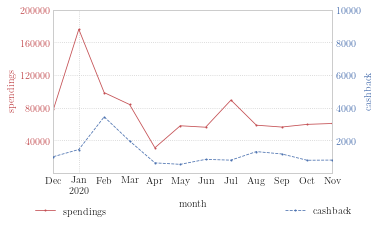

In [78]:
plt.figure(figsize=(5, 3))

ax1 = plt.gca()

monthly_spendings.plot(ax=ax1, lw=0.8, zorder=5,
                       marker='.', markersize=2, color='C3',
                       label='spendings')

# ax1.plot(monthly_spendings, lw=0.8, zorder=5,
#          marker='.', markersize=2, color='C2', label='spendings')

ax1.set_xlabel('month')
ax1.set_ylabel('spendings', color='C3')
# ax1.tick_params(axis='x', rotation=10)
ax1.tick_params(axis='y', labelcolor='C3')
# ax1.grid(ls='dotted')
ax1.legend(loc='upper left', bbox_to_anchor=(-0.1, -0.15))

yticks = np.arange(0, 240000, 40000)
ax1.set_yticks(yticks[1:])
ax1.set_yticklabels(yticks[1:])
ax1.set_ylim(yticks[0], yticks[-1])

ax2 = ax1.twinx()

monthly_cashback.plot(ax=ax2, lw=0.8, zorder=5,
                      marker='.', markersize=2, color='C0',
                      ls='dashed', label='cashback')

# ax2.plot(monthly_cashback_filled, lw=0.8, zorder=5,
#          marker='.', markersize=2, color='C0', ls='dashed', label='cashback')

yticks = yticks // 20
ax2.set_yticks(yticks[1:])
ax2.set_yticklabels(yticks[1:])
ax2.set_ylim(yticks[0], yticks[-1])

ax2.set_ylabel('cashback', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')
ax2.legend(loc='upper right', bbox_to_anchor=(1.1, -0.15))
ax2.grid(False)

plt.savefig('../data/figures/real_spendings_vs_cashback.pdf', transparent=True, bbox_inches='tight')

In [67]:
all_mccs = money_movement.loc[money_movement['mcc'].notna(), 'mcc'].unique().tolist()

cards = [Card(card_id, all_mccs) for card_id in CARD_IDS]

len(cards)

14

In [68]:
profit = []

for month in tqdm(money_movement['month'].unique()):
    vector = money_movement[money_movement['month'] == month].groupby('mcc')['expense'].sum()
    vector = vector.reindex(all_mccs).fillna(0).values
    
    for c in cards:
        p = c.calculate_profit(vector)
        profit.append((c.card_name, 'None', month, p))

    for c1, c2 in combinations(cards, 2):
        _, _, _, p = optimize_cashback_for_cards(vector, c1, c2)
        profit.append((c1.card_name, c2.card_name, month, p))

profit = pd.DataFrame(profit, columns=['c1', 'c2', 'month', 'profit'])

profit.head(2)

  0%|          | 0/12 [00:00<?, ?it/s]

,c1,c2,month,profit
0,Tinkoff Black,None,2019-12-01,706.3379
1,Tinkoff Drive,None,2019-12-01,706.3379


In [69]:
total_profit = profit.groupby(['c1', 'c2'])['profit'].sum().sort_values(ascending=False).reset_index()

total_profit.head()

,c1,c2,profit
0,Bank SPb Cashback,Bank SPb MC World,30592.674259
1,Bank SPb Cashback,Alfabank Alfacard,29815.003309
2,Bank SPb Cashback,Bank SPb Travel,29034.761870
3,Raiffeisen Cashback Card,Bank SPb Cashback,28818.906260
4,Bank SPb Cashback,Sberbank Large Bonuses Card,27385.294334


In [70]:
total_profit[total_profit['c2'] == 'None'].head()

,c1,c2,profit
10,Bank SPb Cashback,None,25586.14210
36,Bank SPb MC World,None,17312.10650
41,Sberbank Large Bonuses Card,None,17250.18645
50,Bank SPb EKP,None,16310.22210
66,Alfabank Alfacard,None,14000.44470


In [71]:
ids = [1, 3, 10, 41]

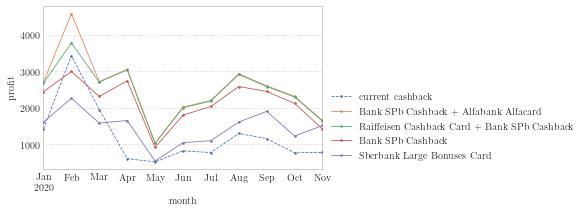

In [75]:
plt.figure(figsize=(5, 3))

monthly_cashback.iloc[1:]\
    .plot(label='current cashback', lw=0.8,
          ls='dashed', marker='.', markersize=3,
          zorder=5, color='C0')

# plt.plot(monthly_cashback_filled, label='Current cashback',
#          lw=0.8, ls='dashed', marker='.', markersize=3, zorder=5, color='C0')

for j, i in enumerate(ids, start=1):
    row = total_profit.loc[i]
    
    c1 = row['c1']
    c2 = row['c2']
    
    cards_profit = profit[(profit['c1'] == c1) & (profit['c2'] == c2)]
    
    label = c1
    
    if c2 != 'None':
        label += ' + ' + c2
    
    color = f'C{j}'
    
    cards_profit.set_index('month')['profit'].shift().iloc[1:]\
        .plot(label=label, lw=0.8,marker='.', markersize=3, zorder=5, color=color)
    
#     plt.plot(cards_profit['month'], cards_profit['profit'], label=label,
#              lw=0.8, marker='.', markersize=3, zorder=5, color=color)
    
plt.legend(loc='lower left', bbox_to_anchor=(1, 0), prop={'size': 10})
# plt.xticks(rotation=10)
# plt.grid(ls='dotted')
plt.xlabel('month')
plt.ylabel('profit')

plt.savefig('../data/figures/monthly_cashback.pdf', transparent=True, bbox_inches='tight')

In [80]:
total_profit

,c1,c2,profit
0,Bank SPb Cashback,Bank SPb MC World,30592.674259
1,Bank SPb Cashback,Alfabank Alfacard,29815.003309
2,Bank SPb Cashback,Bank SPb Travel,29034.761870
3,Raiffeisen Cashback Card,Bank SPb Cashback,28818.906260
4,Bank SPb Cashback,Sberbank Large Bonuses Card,27385.294334
...,...,...,...
100,Raiffeisen Gold,Bank SPb Classic,4668.325550
101,Bank SPb Classic,None,4403.573050
102,Raiffeisen Gold,Bank SPb Pensionary,2236.068100
103,Bank SPb Pensionary,None,1825.905600


In [98]:
mask = profit['c2'] == 'None'

profit_single = profit[mask].groupby('c1')['profit'].sum().sort_index()

profit_single

c1
Alfabank Alfacard              14000.44470
Alfabank Cashback              12733.42525
Alfabank Next                   9209.37000
Bank SPb Cashback              25586.14210
Bank SPb Classic                4403.57305
Bank SPb EKP                   16310.22210
Bank SPb MC World              17312.10650
Bank SPb Pensionary             1825.90560
Bank SPb Travel                13210.71915
Raiffeisen Cashback Card       12524.81115
Raiffeisen Gold                  410.16250
Sberbank Large Bonuses Card    17250.18645
Tinkoff Black                   8738.12560
Tinkoff Drive                   9722.27530
Name: profit, dtype: float64

In [99]:
profit_dual = profit[~mask].groupby(['c1', 'c2'])['profit'].sum().sort_index()

profit_dual

c1                 c2                         
Alfabank Alfacard  Alfabank Next                  20372.868072
                   Sberbank Large Bonuses Card    21438.911310
Alfabank Cashback  Alfabank Alfacard              16850.254173
                   Alfabank Next                  15150.639162
                   Sberbank Large Bonuses Card    17716.880599
                                                      ...     
Tinkoff Drive      Bank SPb Pensionary             9722.275189
                   Bank SPb Travel                14135.900848
                   Raiffeisen Cashback Card       13825.463918
                   Raiffeisen Gold                 9722.275267
                   Sberbank Large Bonuses Card    17537.059894
Name: profit, Length: 91, dtype: float64

In [147]:
features = np.array([
    profit_single[profit_dual.index.get_level_values(0)].values / profit_dual.values,
    profit_single[profit_dual.index.get_level_values(1)].values / profit_dual.values
]).T

features.sort(axis=1)

features = pd.DataFrame(features, index=profit_dual.index)

features

0         1
c1                c2                                             
Alfabank Alfacard Alfabank Next                0.452041  0.687210
                  Sberbank Large Bonuses Card  0.653039  0.804620
Alfabank Cashback Alfabank Alfacard            0.755681  0.830874
                  Alfabank Next                0.607854  0.840455
                  Sberbank Large Bonuses Card  0.718717  0.973658
...                                                 ...       ...
Tinkoff Drive     Bank SPb Pensionary          0.187806  1.000000
                  Bank SPb Travel              0.687772  0.934551
                  Raiffeisen Cashback Card     0.703215  0.905923
                  Raiffeisen Gold              0.042188  1.000000
                  Sberbank Large Bonuses Card  0.554385  0.983642

[91 rows x 2 columns]

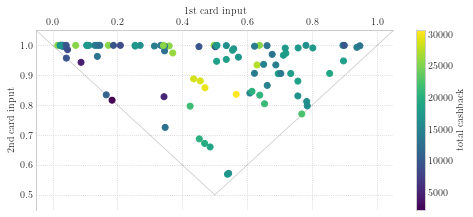

In [173]:
plt.figure(figsize=(8, 3.3))

plt.scatter(*features.values.T, c=profit_dual.values, cmap='viridis', zorder=3)
plt.colorbar(label='total cashback')

plt.plot([-0.5, 0.5], [1.5, 0.5], color='k', alpha=0.2, lw=0.8, zorder=2)
plt.plot([0.5, 1.5], [0.5, 1.5], color='k', alpha=0.2, lw=0.8, zorder=2)
plt.xlim(-0.05, 1.05)
plt.ylim(0.45, 1.05)

plt.tick_params(labelbottom=False, labeltop=True)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel('1st card input')
plt.gca().xaxis.set_label_position('top')

plt.ylabel('2nd card input')

plt.savefig('../data/figures/card_input.pdf', transparent=True, bbox_inches='tight')

array([0.6872103 , 0.65303898, 0.75568149, 0.84045466, 0.71871711,
       0.50545047, 0.85816332, 1.        , 0.9981236 , 1.        ,
       0.83634866, 1.        , 0.88122445, 0.93430225, 0.31384553,
       0.34499943, 0.34695643, 0.17210774, 0.26998854, 0.25436379,
       0.8282802 , 0.33333333, 0.254673  , 0.88043165, 1.        ,
       0.98833226, 0.90595821, 0.89626834, 0.99134793, 0.96680837,
       0.79668233, 0.90608079, 0.99134793, 0.7705346 , 0.13041769,
       0.13810357, 0.16546082, 0.11194854, 0.10546987, 0.13821394,
       0.10584846, 0.93745089, 0.81221815, 0.67205231, 0.63836027,
       0.89460095, 0.78463285, 0.66019539, 0.43460397, 0.98158079,
       0.69520243, 0.71683528, 1.        , 0.94670563, 0.99577061,
       0.6144332 , 0.02929639, 0.03221148, 0.04263851, 0.01603065,
       0.08786073, 0.02514757, 0.02369224, 0.18343024, 0.0310477 ,
       0.02377728, 0.62230287, 0.62209114, 0.54255128, 0.3413474 ,
       0.99534112, 0.53532588, 0.50436841, 1.00000001, 0.66080

Index(['Alfabank Alfacard', 'Alfabank Alfacard', 'Alfabank Cashback',
       'Alfabank Cashback', 'Alfabank Cashback', 'Alfabank Next',
       'Bank SPb Cashback', 'Bank SPb Cashback', 'Bank SPb Cashback',
       'Bank SPb Cashback', 'Bank SPb Cashback', 'Bank SPb Cashback',
       'Bank SPb Cashback', 'Bank SPb Cashback', 'Bank SPb Classic',
       'Bank SPb Classic', 'Bank SPb Classic', 'Bank SPb Classic',
       'Bank SPb Classic', 'Bank SPb Classic', 'Bank SPb Classic',
       'Bank SPb Classic', 'Bank SPb Classic', 'Bank SPb EKP', 'Bank SPb EKP',
       'Bank SPb EKP', 'Bank SPb EKP', 'Bank SPb EKP', 'Bank SPb MC World',
       'Bank SPb MC World', 'Bank SPb MC World', 'Bank SPb MC World',
       'Bank SPb MC World', 'Bank SPb MC World', 'Bank SPb Pensionary',
       'Bank SPb Pensionary', 'Bank SPb Pensionary', 'Bank SPb Pensionary',
       'Bank SPb Pensionary', 'Bank SPb Pensionary', 'Bank SPb Pensionary',
       'Bank SPb Travel', 'Bank SPb Travel', 'Bank SPb Travel',
       '